In [4]:
import os, csv, cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random as rand
from IPython.display import clear_output

In [20]:
dataPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\icml_face_data.csv"
headPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\head.txt"
predictionsPath_control = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\predictions_control.csv"
predictionsPath_coverEyes = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\predictions_cover_eyes.csv"
predictionsPath_coverMouth = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\predictions_cover_mouth.csv"
predictionsPath_upsideDown = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\predictions_upsideDown.csv"
eyesCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_eye.xml"
mouthCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_mouth.xml"
upscalePath = "EDSR_x4.pb"

#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
validLabels = {"0": "angry", "1": "disgust", "2": "fear", "3": "happy", "4": "sad", "5": "suprise", "6": "neutral",
                "angry": "0", "disgust": "1", "fear": "2", "happy": "3", "sad": "4", "surprise": "5", "neutral": "6"}

#upside_down' 'cover_eyes', 'cover_mouth'
validFilters = ["none", "upside_down", "cover_eyes", "cover_mouth"]


imgW = 48
imgH = 48

def apply_coverEyes_filter(pixelData):
    multichannel = np.stack((pixelData,)*3, axis=-1)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(upscalePath)
    sr.setModel("edsr",4)
    upsampled = sr.upsample(multichannel)
    eyeSnip = upsampled[20:120,:,0].astype("uint8")

    eyesCascade = cv2.CascadeClassifier(eyesCascadePath)
    eyes = eyesCascade.detectMultiScale(eyeSnip, scaleFactor = 1.1, minNeighbors = 4)
    
    points = []
    if(len(eyes) == 0):
        avgColor = np.average(pixelData)
    for (x,y,width,height) in eyes:
        sx = x//4
        sy = (y+20)//4
        sw = width//4
        sh = height//4
        avgColor = np.average(pixelData[sy:sy+sh, sx:sx+sh, ])
#         cv2.rectangle(pixelData, (sx,sy), (sx+sw,sy+sh), (255), 1)
        points.append((sx + sw//2, 47-(sy + sh//2)))
    
    if(len(points) == 0):
        cv2.line(pixelData, (0, 15), (47, 15), (avgColor), 10)
    elif(len(points) == 1 or abs(points[0][0] - points[1][0]) < 1):
        cv2.line(pixelData, (0, 47-points[0][1]), (47, 47-points[0][1]), (avgColor), 10)
    else:
        m = (points[0][1]-points[1][1]) / (points[0][0] - points[1][0])
        y1 = int(m*(-points[0][0]) + points[0][1])
        y2 = int(m*(47-points[0][0]) + points[0][1])
        cv2.line(pixelData, (0, 47-y1), (47, 47-y2), (avgColor), 10)


def apply_coverMouth_filter(pixelData):
    multichannel = np.stack((pixelData,)*3, axis=-1)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(upscalePath)
    sr.setModel("edsr",4)
    upsampled = sr.upsample(multichannel)
    mouthSnip = upsampled[80:180,:,0].astype("uint8")

    mouthCascade = cv2.CascadeClassifier(mouthCascadePath)
#     1.15, 2
    mouths = mouthCascade.detectMultiScale(mouthSnip, scaleFactor = 1.15, minNeighbors = 6)
    
    if(len(mouths) > 0):
        (x,y,width,height) = mouths[-1]
        sx = x//4
        sy = (y+80)//4
        sw = width//4
        sh = height//4
        avgColor = np.average(pixelData[sy:sy+sh, sx:sx+sw])
        cv2.line(pixelData, (0, sy+sh//2), (47, sy+sh//2), (avgColor), sh)
    else:
        avgColor = np.average(pixelData)
        cv2.line(pixelData, (0, 35), (47, 35), (avgColor), 10) 

Are you sure you want to generate this data? Type 'Generate Data' to confirm

Generate Data
Test Image:



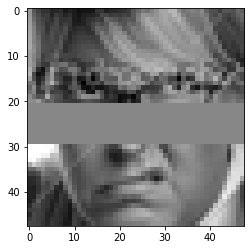

0.00% complete
2.79% complete
5.57% complete
8.36% complete
11.15% complete
13.94% complete
16.72% complete
19.51% complete
22.30% complete
25.08% complete
27.87% complete
30.66% complete
33.44% complete
36.23% complete
39.02% complete
41.81% complete
44.59% complete
47.38% complete
50.17% complete
52.95% complete
55.74% complete
58.53% complete
61.32% complete
64.10% complete
66.89% complete
69.68% complete
72.46% complete
75.25% complete
78.04% complete
80.82% complete
83.61% complete
86.40% complete
89.19% complete
91.97% complete
94.76% complete
97.55% complete
Data Generated


In [3]:
#'none', 'upside_down' 'cover_eyes', 'cover_mouth'
FILTER = 'cover_mouth'



if(FILTER in validFilters):

    confirm = input("Are you sure you want to generate this data? Type 'Generate Data' to confirm\n\n")
    if(confirm == "Generate Data"):

        with open(dataPath, 'r') as f:
            with open("data_filtered_{}.csv".format(FILTER), 'w') as out:

                data = f.readlines()[-3589:-1]
                out.write("emotion, Usage, pixels")
                for i, line in enumerate(data):
                    out.write("\n")
                    faceData = line.strip("\n")
                    useIndex = faceData.find(",")
                    pixIndex = faceData.rfind(",")
                    if(faceData[useIndex+1:pixIndex] != "PrivateTest"):
                        print("ERROR: wrong data usage!")
                        print(faceData[useIndex+1:pixIndex])
                    pixels = faceData[pixIndex+1:].split(" ")
                    pixelData = np.asarray(pixels).reshape(imgH, imgW).astype("uint8")

                    if(FILTER == 'cover_eyes'):
                        apply_coverEyes_filter(pixelData)
                    elif(FILTER == 'upside_down'):
                        pixelData = np.rot90(pixelData, k=2)
                    elif(FILTER == 'cover_mouth'):
                        apply_coverMouth_filter(pixelData)
                    
                    if i == 0:
                        print("Test Image:\n")
                        plt.imshow(pixelData, cmap='gray')
                        plt.show()
                        
                    outPix = pixelData.flatten()
                    outPix = np.char.mod('%d', outPix)
                    outPix = ' '.join(outPix)
                    out.write(faceData[:pixIndex+1] + outPix)
                    
                    if i%100 == 0:
                        pcnt = i*100 / len(data)
                        print(f"{pcnt:.2f}% complete")
                        
                print("Data Generated")
    else:
        print("Generation canceled")
else:
    print("Not a valid filter")

In [21]:
# Assess Accuracy from Predictions File

with open(predictionsPath_control, 'r') as p:
    predictions = [line.split(", ")[1].strip("\n") for line in p.readlines()]
    trues = [prediction for prediction in predictions if prediction == "True"]
    trueCount = len(trues)
    falseCount = len(predictions) - trueCount
    accuracy = trueCount / len(predictions)
    print(f"Prediction Accuracy: {accuracy:.3f}")

Prediction Accuracy: 0.629
